In [2]:
!git clone https://github.com/AryanKumarNadipally/Autonomous-Driving-using-Behavioral-Cloning.git

Cloning into 'Autonomous-Driving-using-Behavioral-Cloning'...
remote: Enumerating objects: 15919, done.
remote: Total 15919 (delta 0), reused 0 (delta 0), pack-reused 15919
Receiving objects: 100% (15919/15919), 200.25 MiB | 35.20 MiB/s, done.
Updating files: 100% (15916/15916), done.


In [3]:
!ls Autonomous-Driving-using-Behavioral-Cloning

driving_log.csv  IMG


In [4]:
!pip3 install imgaug

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ntpath
import random
import cv2
import matplotlib.image as mpimg
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa

In [6]:
# Set directory and column names
data_directory = 'Autonomous-Driving-using-Behavioral-Cloning'
column_names = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']



In [7]:
# Load and display data
drive_data = pd.read_csv(os.path.join(data_directory, 'driving_log.csv'), names = column_names)
pd.set_option('display.max_colwidth', None)
drive_data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Anish Sai Racha\Desktop\udacity_simulator_data\IMG\center_2023_12_14_22_02_02_441.jpg,C:\Users\Anish Sai Racha\Desktop\udacity_simulator_data\IMG\left_2023_12_14_22_02_02_441.jpg,C:\Users\Anish Sai Racha\Desktop\udacity_simulator_data\IMG\right_2023_12_14_22_02_02_441.jpg,0.0,0.0,0.0,0.000054
1,C:\Users\Anish Sai Racha\Desktop\udacity_simulator_data\IMG\center_2023_12_14_22_02_02_542.jpg,C:\Users\Anish Sai Racha\Desktop\udacity_simulator_data\IMG\left_2023_12_14_22_02_02_542.jpg,C:\Users\Anish Sai Racha\Desktop\udacity_simulator_data\IMG\right_2023_12_14_22_02_02_542.jpg,0.0,0.0,0.0,0.000051
2,C:\Users\Anish Sai Racha\Desktop\udacity_simulator_data\IMG\center_2023_12_14_22_02_02_644.jpg,C:\Users\Anish Sai Racha\Desktop\udacity_simulator_data\IMG\left_2023_12_14_22_02_02_644.jpg,C:\Users\Anish Sai Racha\Desktop\udacity_simulator_data\IMG\right_2023_12_14_22_02_02_644.jpg,0.0,0.0,0.0,0.000050
3,C:\Users\Anish Sai Racha\Desktop\udacity_simulator_data\IMG\center_2023_12_14_22_02_02_745.jpg,C:\Users\Anish Sai Racha\Desktop\udacity_simulator_data\IMG\left_2023_12_14_22_02_02_745.jpg,C:\Users\Anish Sai Racha\Desktop\udacity_simulator_data\IMG\right_2023_12_14_22_02_02_745.jpg,0.0,0.0,0.0,0.000052
4,C:\Users\Anish Sai Racha\Desktop\udacity_simulator_data\IMG\center_2023_12_14_22_02_02_847.jpg,C:\Users\Anish Sai Racha\Desktop\udacity_simulator_data\IMG\left_2023_12_14_22_02_02_847.jpg,C:\Users\Anish Sai Racha\Desktop\udacity_simulator_data\IMG\right_2023_12_14_22_02_02_847.jpg,0.0,0.0,0.0,0.000051


In [8]:
# Function to extract filename from path
def extract_filename(path):
    head, tail = ntpath.split(path)
    return tail

In [9]:
# Apply filename extraction
drive_data['center'] = drive_data['center'].apply(extract_filename)
drive_data['left'] = drive_data['left'].apply(extract_filename)
drive_data['right'] = drive_data['right'].apply(extract_filename)
drive_data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2023_12_14_22_02_02_441.jpg,left_2023_12_14_22_02_02_441.jpg,right_2023_12_14_22_02_02_441.jpg,0.0,0.0,0.0,0.000054
1,center_2023_12_14_22_02_02_542.jpg,left_2023_12_14_22_02_02_542.jpg,right_2023_12_14_22_02_02_542.jpg,0.0,0.0,0.0,0.000051
2,center_2023_12_14_22_02_02_644.jpg,left_2023_12_14_22_02_02_644.jpg,right_2023_12_14_22_02_02_644.jpg,0.0,0.0,0.0,0.000050
3,center_2023_12_14_22_02_02_745.jpg,left_2023_12_14_22_02_02_745.jpg,right_2023_12_14_22_02_02_745.jpg,0.0,0.0,0.0,0.000052
4,center_2023_12_14_22_02_02_847.jpg,left_2023_12_14_22_02_02_847.jpg,right_2023_12_14_22_02_02_847.jpg,0.0,0.0,0.0,0.000051


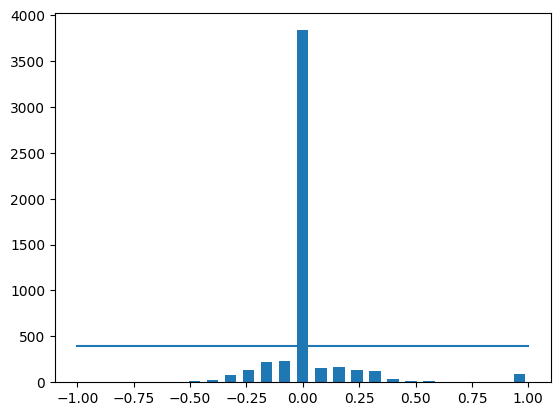

In [10]:
# Steering angle analysis
num_bins = 25
max_samples = 400
steering_hist, steering_bins = np.histogram(drive_data['steering'], num_bins)
mid_bin = (steering_bins[:-1] + steering_bins[1:]) * 0.5
plt.bar(mid_bin, steering_hist, width=0.05)
plt.plot((np.min(drive_data['steering']), np.max(drive_data['steering'])), (max_samples, max_samples))


In [16]:
# Data balancing

print('Total data:', len(drive_data))
data_to_remove = []
for i in range(num_bins):
    bin_list = []
    for j in range(len(drive_data['steering'])):
        if steering_bins[i] <= drive_data['steering'][j] < steering_bins[i + 1]:
            bin_list.append(j)
    bin_list = shuffle(bin_list)
    bin_list = bin_list[max_samples:]
    data_to_remove.extend(bin_list)

Total data: 5305


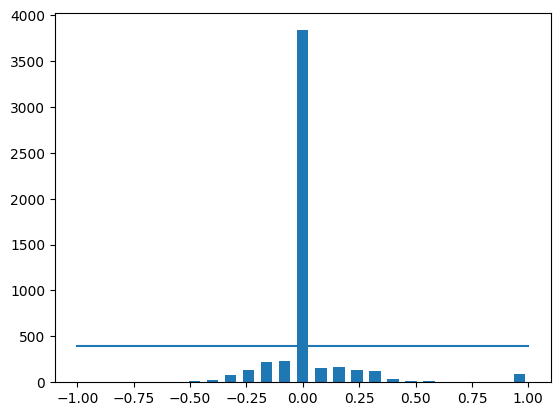

In [17]:
# Histogram of balanced data
balanced_hist, _ = np.histogram(drive_data['steering'], num_bins)
plt.bar(mid_bin, balanced_hist, width=0.05)
plt.plot((np.min(drive_data['steering']), np.max(drive_data['steering'])), (max_samples, max_samples))

In [18]:
# Display a sample data row
print(drive_data.iloc[1])

center      center_2023_12_14_22_02_02_542.jpg
left          left_2023_12_14_22_02_02_542.jpg
right        right_2023_12_14_22_02_02_542.jpg
steering                                   0.0
throttle                                   0.0
reverse                                    0.0
speed                                 0.000051
Name: 1, dtype: object


In [19]:
# Function to load images and steering data
def load_images_and_steering(data_dir, dataframe):
    image_paths, steerings = [], []
    for index in range(len(dataframe)):
        record = dataframe.iloc[index]
        center, left, right = record['center'], record['left'], record['right']
        image_paths.append(os.path.join(data_dir, center))
        steerings.append(float(record['steering']))
        # Adjust steering for side images
        image_paths.append(os.path.join(data_dir, left))
        steerings.append(float(record['steering']) + 0.15)
        image_paths.append(os.path.join(data_dir, right))
        steerings.append(float(record['steering']) - 0.15)
    return np.array(image_paths), np.array(steerings)

In [20]:
# Load and split data
image_dir = data_directory + '/IMG'
image_paths, steer_angles = load_images_and_steering(image_dir, drive_data)
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steer_angles, test_size=0.2, random_state=6)


Text(0.5, 1.0, 'Validation Set Distribution')

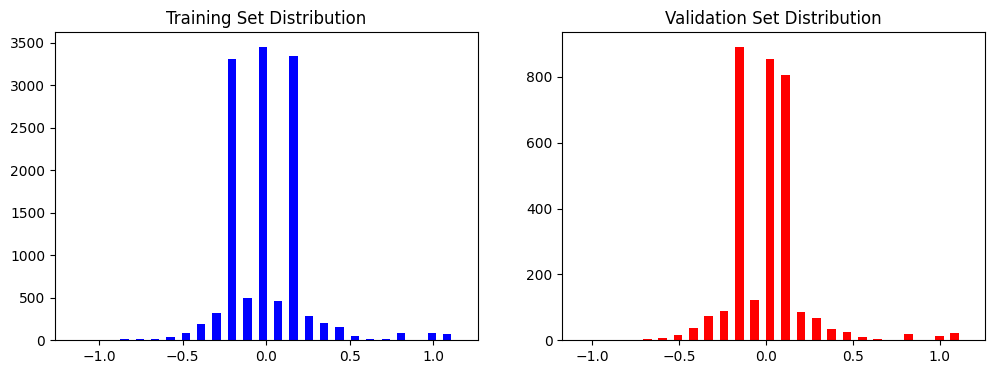

In [21]:
# Visualization of training and validation set
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training Set Distribution')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation Set Distribution')

In [22]:
# Image augmentation functions
def augment_zoom(image):
    zoom_aug = iaa.Affine(scale=(1, 1.3))
    return zoom_aug.augment_image(image)

def augment_pan(image):
    pan_aug = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
    return pan_aug.augment_image(image)

def augment_brightness(image):
    brightness_aug = iaa.Multiply((0.2, 1.2))
    return brightness_aug.augment_image(image)

def augment_flip(image, steering_angle):
    flipped_image = cv2.flip(image, 1)
    return flipped_image, -steering_angle

Text(0.5, 1.0, 'Brightness Adjusted Image')

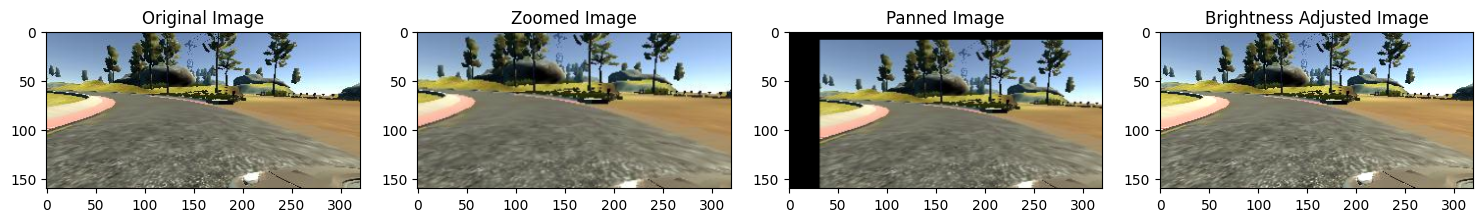

In [23]:
# Example of augmentation
index = random.randint(0, 1000)
sample_image = mpimg.imread(image_paths[index])
fig, axs = plt.subplots(1, 4, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(sample_image)
axs[0].set_title('Original Image')
axs[1].imshow(augment_zoom(sample_image))
axs[1].set_title('Zoomed Image')
axs[2].imshow(augment_pan(sample_image))
axs[2].set_title('Panned Image')
axs[3].imshow(augment_brightness(sample_image))
axs[3].set_title('Brightness Adjusted Image')

In [24]:
# Combined random augmentation function
def augment_image(image_path, steering_value):
    image = mpimg.imread(image_path)
    if np.random.rand() < 0.5:
        image = augment_pan(image)
    if np.random.rand() < 0.5:
        image = augment_zoom(image)
    if np.random.rand() < 0.5:
        image = augment_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_value = augment_flip(image, steering_value)
    return image, steering_value

In [25]:
# Image preprocessing
def preprocess_image(img):
    img = img[60:135, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img / 255
    return img


In [26]:
# Preprocess and visualize an example image
sample_image_path = image_paths[100]
original_img = mpimg.imread(sample_image_path)
processed_img = preprocess_image(original_img)



In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_img)
axs[0].set_title('Original Image')
axs[1].imshow(processed_img)
axs[1].set_title('Preprocessed Image')



In [27]:
# Batch generator for model training
def batch_generator(image_paths, steering_angles, batch_size, is_training):
    while True:
        batch_images = []
        batch_steering_angles = []

        for i in range(batch_size):
            index = random.randint(0, len(image_paths) - 1)
            if is_training:
                img, steering = augment_image(image_paths[index], steering_angles[index])
            else:
                img = mpimg.imread(image_paths[index])
                steering = steering_angles[index]

            img = preprocess_image(img)
            batch_images.append(img)
            batch_steering_angles.append(steering)

        yield np.array(batch_images), np.array(batch_steering_angles)


In [28]:
# NVIDIA model architecture
def create_nvidia_model():
    model = Sequential()
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(64, (3, 3), activation='elu'))

    model.add(Conv2D(64, (3, 3), activation='elu'))
    model.add(Dropout(0.5))
    model.add(Flatten())

    model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.5))

    model.add(Dense(50, activation='elu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='elu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.compile(loss='mse', optimizer=Adam(lr=0.001))
    return model


In [29]:
# Create and display the model
model = create_nvidia_model()
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 dropout (Dropout)           (None, 1, 18, 64)         0         
                                                                 
 flatten (Flatten)           (None, 1152)              0

In [30]:
# Model training
training_generator = batch_generator(X_train, y_train, 100, True)
validation_generator = batch_generator(X_valid, y_valid, 100, False)

training_history = model.fit(training_generator,
                             steps_per_epoch=300,
                             epochs=10,
                             validation_data=validation_generator,
                             validation_steps=200,
                             verbose=1,
                             shuffle=1)

Epoch 1/10
300/300 [==============================] - 348s 1s/step - loss: 0.1409 - val_loss: 0.0452
Epoch 2/10
300/300 [==============================] - 352s 1s/step - loss: 0.0541 - val_loss: 0.0426
Epoch 3/10
300/300 [==============================] - 331s 1s/step - loss: 0.0545 - val_loss: 0.0449
Epoch 4/10
300/300 [==============================] - 332s 1s/step - loss: 0.0520 - val_loss: 0.0457
Epoch 5/10
300/300 [==============================] - 352s 1s/step - loss: 0.0522 - val_loss: 0.0396
Epoch 6/10
300/300 [==============================] - 338s 1s/step - loss: 0.0506 - val_loss: 0.0419
Epoch 7/10
300/300 [==============================] - 354s 1s/step - loss: 0.0506 - val_loss: 0.0397
Epoch 8/10
300/300 [==============================] - 355s 1s/step - loss: 0.0522 - val_loss: 0.0415
Epoch 9/10
300/300 [==============================] - 350s 1s/step - loss: 0.0488 - val_loss: 0.0411
Epoch 10/10
300/300 [==============================] - 338s 1s/step - loss: 0.0497 - val_lo

Text(0.5, 0, 'Epoch')

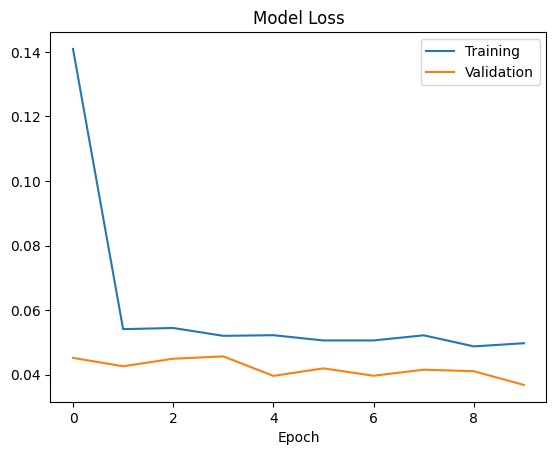

In [31]:
# Plotting training results
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Model Loss')
plt.xlabel('Epoch')

In [32]:
# Save the trained model
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
# Download the model file (specific to Google Colab environment)
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>